# Malicious DNS-over-HTTP Traffic Detection with Anomaly Detection Machine Learning

In this notebook, we explore the use of anomaly detection machine learning techniques to detect malicious DoH traffic. The notebook will guide your through loading a DoH traffic dataset, preparing the datasets, training machine learning models, and evaluating their effectiveness in identifying malicious traffic. 

## The anomaly detection machine learning workflow

The steps to train and use an anomaly detection machine learning model are usually as follows: 
 1. Load data
 2. Prepare training and testing datasets for training phase. These dataset only includes normal data. 
 3. Prepare an evaluation dataset that contains both normal and malicious data. 
 4. Run a training algorithm using the training and testing dataset.
 5. Run inference with the trained ML model using the evaluation dataset and measure performance. 
 6. Visualize the ML model's performance
 
The rest of this notebook will follow these steps to train anomaly detection (i.e., semi-supervised) machine learning models to detect malicious DoH traffic.  

## Load the DoH traffic data
We start by loading the data sets we created in notebook 1. 

In [64]:
# Import the pandas library
import pandas as pd

# Load the datasets into Pandas dataframes
data_training = pd.read_csv('data_training.csv')
data_testing  = pd.read_csv('data_testing.csv')

# Get the labels
training_labels   = data_training['is_doh']
testing_labels = data_testing['is_doh']

# Drop the label columns
label_col = 'is_doh'
data_training   = data_training.drop(columns = label_col)
data_testing = data_testing.drop(columns = label_col)


## Training of Anomaly Detection ML Models

Now that we have our data sets ready, we can start the training phase. The first step is to choose the anomaly detection models that we want to use. For this notebook, we will be using Isolation Forest, Local Outlier Factor, and One-class support vector machine. 

IF, LOF, and OCSVM are traditional ML models. These models have low training and inference times but may not be able to accurately model complex data. In contrast, deep learning can model very complex data but requires a longer training time. 

We will train only ML models in this notebook. The next notebook explores the use of autoencoders, a deep
learning model.

### Isolation Forest
Isolation Forests (IF) are the anomaly detection cousins of random forests. An isolation forest is formed
by multiple isolation trees. Isolation Forests are a form of semi-supervised learning and thus we do not
need to supply the labels of each sample.  

The main idea of an isolation tree is that anomalous data can be isolated with fewer partitions than
non-anomolous data. For example, consider the points $x_i$ and $x_j$. We need to create several
partitions before we can find a rectangle that only contains $x_i$. In contrast, we only need a few
partitions to isolate $x_j$ into its own rectangle. Consequently, $x_j$ is anomalous.  

![Non-anomolous data point](https://upload.wikimedia.org/wikipedia/commons/c/ce/Isolating_a_Non-Anomalous_Point.png)
![Anomolous data point](https://upload.wikimedia.org/wikipedia/commons/f/ff/Isolating_an_Anomalous_Point.png)

Source: [Wikipedia](https://en.wikipedia.org/wiki/Isolation_forest)

The data partitions can be represented by a binary tree. The leaf nodes in binary trees describe the subset of data contained in a rectabgle. Samples in a rectangle share common features. Since anomalies will have certain very different features, the path from the node to the leaf will be short. The binary trees are build roughly as follows:

1. Randomly sample N instances from your training dataset.

At each node of the binary tree:

   2. Randomly choose a feature to split the dataset upon.

   3. Randomly choose a split value from a uniform distribution spanning from the minimum value to the maximum    value of the feature chosen in Step 2.

Stop when you reach a maximum height. Anomalies will be in the leaves with shortest path to root. 

![Isolation tree](https://content.linkedin.com/content/dam/engineering/site-assets/images/blog/posts/2019/08/IsolationForest1.png)
Source: Linkedin Learning: [Isolation Forest](https://engineering.linkedin.com/blog/2019/isolation-forest)

In [182]:
from sklearn.ensemble import IsolationForest
from time import perf_counter
import joblib

# We are using a subset of the training dataset. This can later be increased to improve performance. 
training_samples = 100

seed = 1

#Initilizae Isoloation Forest Model. This is where you can change its parameters
model_if = IsolationForest(n_estimators=50, max_samples=0.005, \
                           max_features=0.1,  \
                           random_state =seed)

# Train the isolation forest.
model_if = model_if.fit(data_training)#.sample(n=training_samples))


#Save the model in case we need it later
joblib.dump(model_if, 'Isolation_Forest.sav')


['Isolation_Forest.sav']

#### Visualizing the Isolation Forest
We can plot one of the binary trees in the IsolationForest

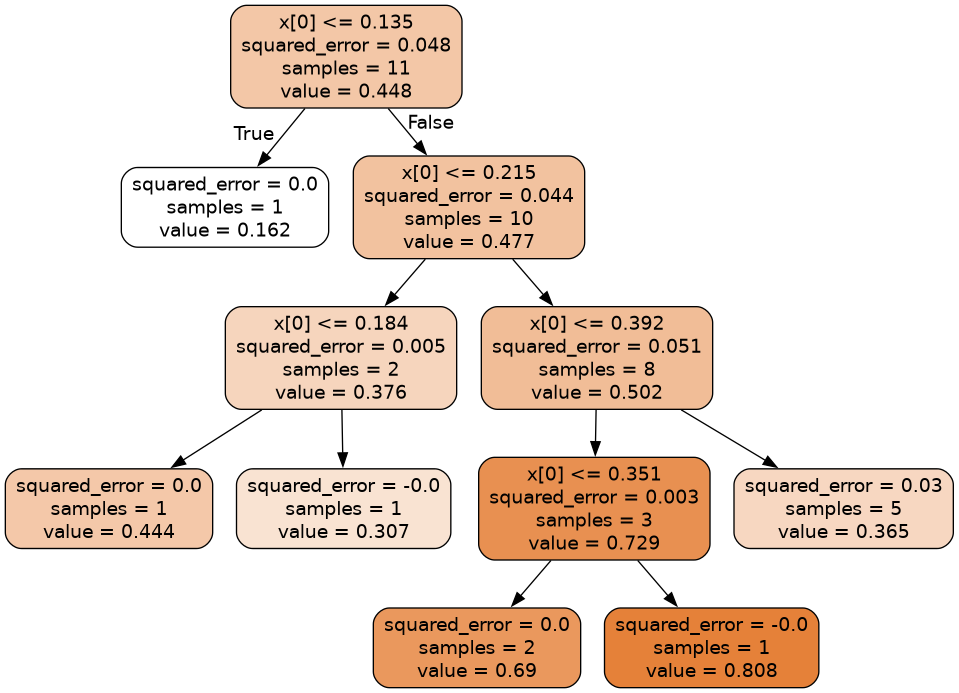

In [151]:
# Extract a binary tree from the IsolationForest object
tree = model_if.estimators_[0]

from sklearn.tree import export_graphviz
import pydot
import graphviz
from IPython.display import Image

graph_data = export_graphviz(
    tree,
    out_file="isolation_tree.dot",
    #feature_names=data_training.columns.to_list(),
    class_names=['normal', 'malicious'],
    rounded=True,
    filled=True
)


'''
Convert the .dot file to .png
'''
(graph,) = pydot.graph_from_dot_file('isolation_tree.dot')
graph.write_png('isolation_tree.png')
Image('isolation_tree.png')

The first line in every node is the feature value threshold used to split the dataset. Samples denotes
the number of samples that fall under the nodes. Value and squared error are values used to measure how
well the node partitions the data according to their lables, i.e., malicoius or benign.  

### Evaluating the Isolation Forest
We can now evaluate how well our trained isolation forest can indentify malicious DoH traffic. We do this be asking it to assign an anomaly score to each sample in our evaluation dataset. A high anomaly score corresponds to malicious data and a low anomaly score represents normal data. However, how high should the anomaly score be is hard to tell until we test it. Next, we calculate several performance metrics for the isolation forest. But first we define a few helper functions. 

### Helper Functions

In [166]:
# Import numerical operations library
import numpy as np
#Import ML metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score, f1_score, average_precision_score, \
confusion_matrix, precision_score, recall_score, accuracy_score

# Function to predict labels based on the best threshold. 
def predict_labels(fpr, tpr, thresholds, data):

    # Calculate best ROC threshold  using the Youden index
    #J_index = tpr-fpr
    #best = np.argmax(J_index)
    threshold = thresholds[np.argmax(tpr-fpr)] # Point on ROC curve colsest to the top-left corner.

    # Predict the labels
    predicted_labels_roc = data.copy()
    predicted_labels_roc[data>threshold]  = -1
    predicted_labels_roc[data<=threshold] = 1

    return predicted_labels_roc

# Function to calculate metrics and save to a dataframe
def get_metrics(true_labels, predicted_labels, scores, positive_label=-1):

        # calculate and save accuracy, precision, recall, and f1-score
        acc = accuracy_score(true_labels, predicted_labels)
        prec = precision_score(true_labels, predicted_labels)
        rec = recall_score(true_labels, predicted_labels)
        f1 = f1_score(true_labels, predicted_labels)
        auc = roc_auc_score(true_labels*-1, scores)
        ap = average_precision_score(true_labels*-1,scores,pos_label=positive_label)

        tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
        fpr = fp/(fp+tn)


        # Save the metrics
        metricNames = ['accuracy','precision', 'recall(TPR)', 'FPR', 'f1-score', 'AUC','AP','TN', 'FP', 'FN', 'TP']
        d = {'metric':metricNames,
              'value':[acc, prec, rec, fpr, f1, auc, ap, tn, fp, fn, tp]}
        df = pd.DataFrame(data=d)

        return df

### Receiver Operating Characteristic Curve

The ROC curve is a measure of how well the model can understand the data. An ideal ROC curve goes straight up from (0,0) to (0,1), and then across to (1,1). The worst ROC curve is a diagonal line from (0,0) to (1,1). The ROC curve also helps us find the best anomaly detection score to use as a threshold. 

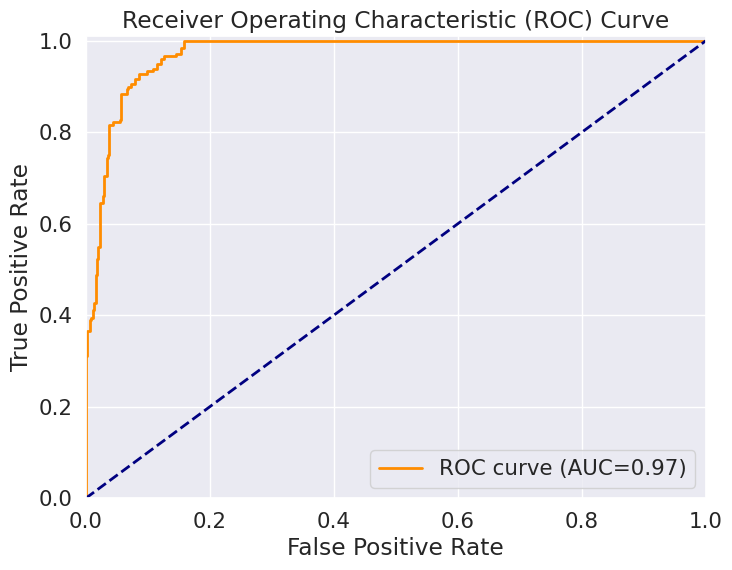

In [164]:
import matplotlib.pyplot as plt
# Get anomaly scores for samples in the evaluation dataset
scores_if  = model_if.decision_function(data_testing)*-1

# Set the positive label to make it consistent across models. 
positive_label=-1


# Get the Receiver Operator Curve 
fpr, tpr, thresholds = roc_curve(testing_labels, scores_if, pos_label=positive_label)

# Calculate the area under the curve
roc_auc = auc(fpr, tpr)

#Visualize the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC={roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Final ML model metrics
Based on the threshold we found with the ROC curve we predict whether the samples are normal or malicious 

In [165]:
# Use the isolation forest to predic the labels
predicted_labels     = predict_labels(fpr, tpr, thresholds, scores_if)

# Calculate the labels
metrics_if           = get_metrics(testing_labels, predicted_labels, scores_if)
metrics_if

,metric,value
0,accuracy,0.914921
1,precision,0.972678
2,recall(TPR),0.914384
3,FPR,0.083333
4,f1-score,0.942630
5,AUC,0.027568
6,AP,0.906280
7,TN,165.000000
8,FP,15.000000
9,FN,50.000000


## Confusion Matrix
The confusion matrix allows us to see how many samples were misclassified. 

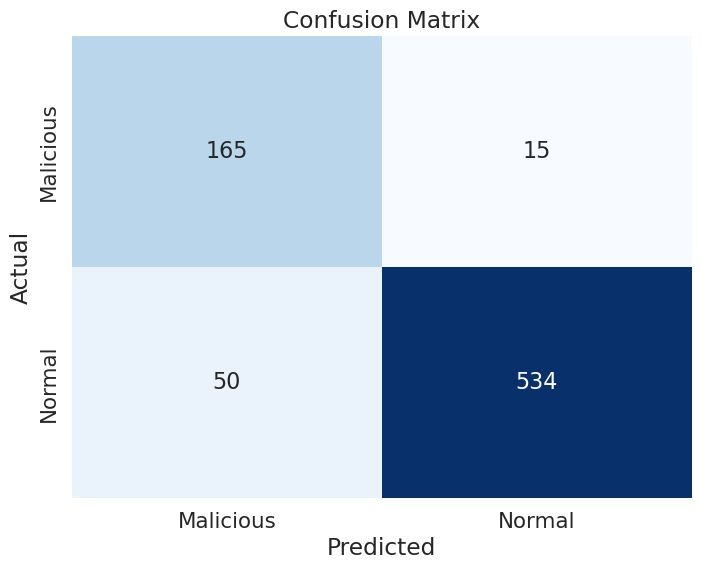

In [169]:
# Plot the confusion matrix
import seaborn as sns


# Confusion matrix
cm = confusion_matrix(testing_labels, predicted_labels, labels=[-1,1])

sns.set(font_scale=1.4)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size":16}, cbar=False, \
           xticklabels = ['Malicious','Normal'], yticklabels = ['Malicious','Normal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Visualizing the predictions

In [179]:
# Build dataframes for visualizing predictions and original data
predicted_labels_df = pd.DataFrame(data = predicted_labels)
predicted_labels_df = predicted_labels_df.rename(columns = {0:label_col})

data_predicted = pd.concat([data_testing, predicted_labels_df], axis = 1)
data_true = pd.concat([data_testing, testing_labels], axis = 1)

## Predicted data

/tmp/ipykernel_133308/3005515689.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_predicted[label_col][data_predicted[label_col] == -1] = "malicious"
/tmp/ipykernel_133308/3005515689.py:1: FutureWarning: Setting an item of incompatib

<function matplotlib.pyplot.show(close=None, block=None)>

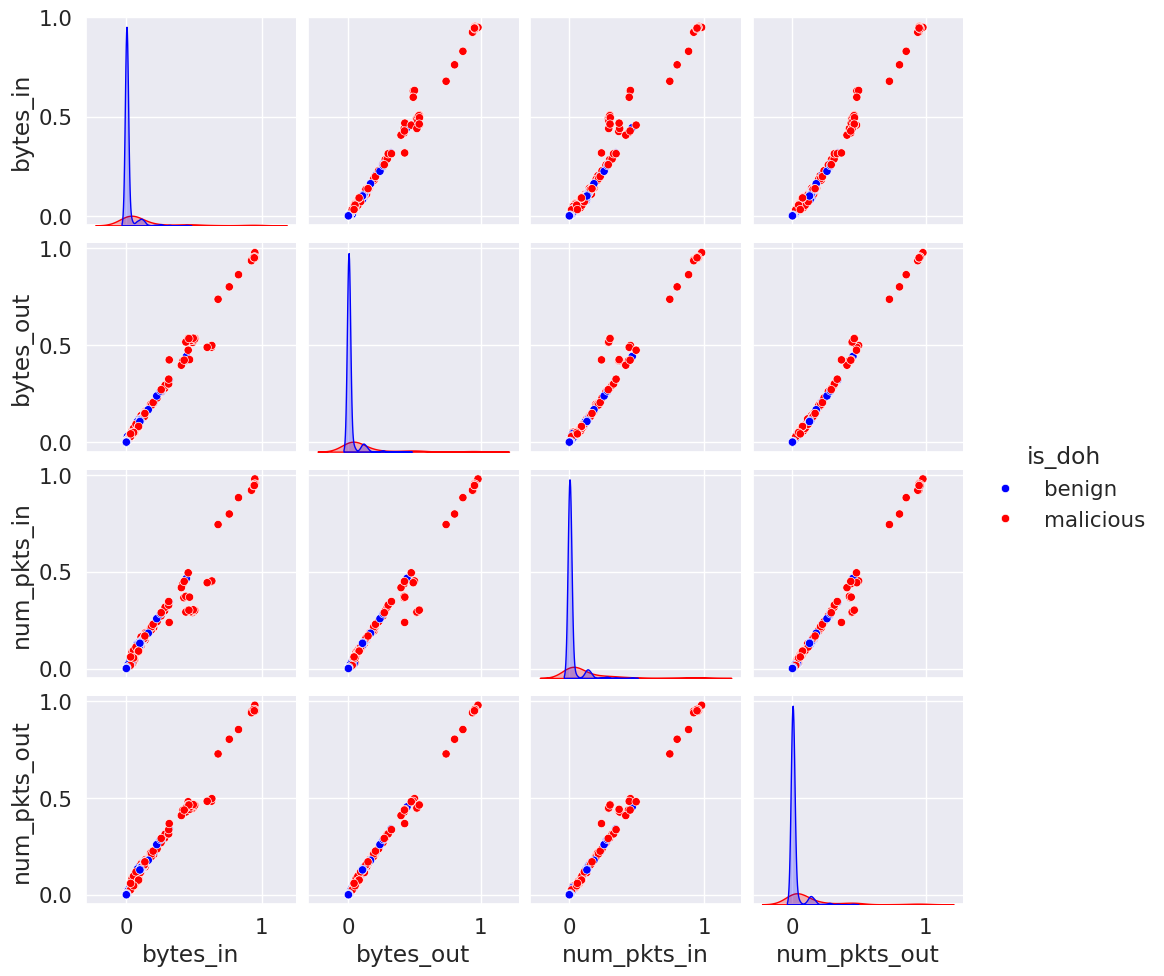

In [180]:
data_predicted[label_col][data_predicted[label_col] == -1] = "malicious"
data_predicted[label_col][data_predicted[label_col] == 1] = "benign"
data_predicted = data_predicted.sample(frac=1)

subset1 = ['bytes_in', 'bytes_out', 'num_pkts_in', 'num_pkts_out']
sns.pairplot(data_predicted, vars= subset1, diag_kind='kde', hue=label_col, palette= {'malicious':'red','benign':'blue' })
plt.show

## Visualizing the ground truth

<function matplotlib.pyplot.show(close=None, block=None)>

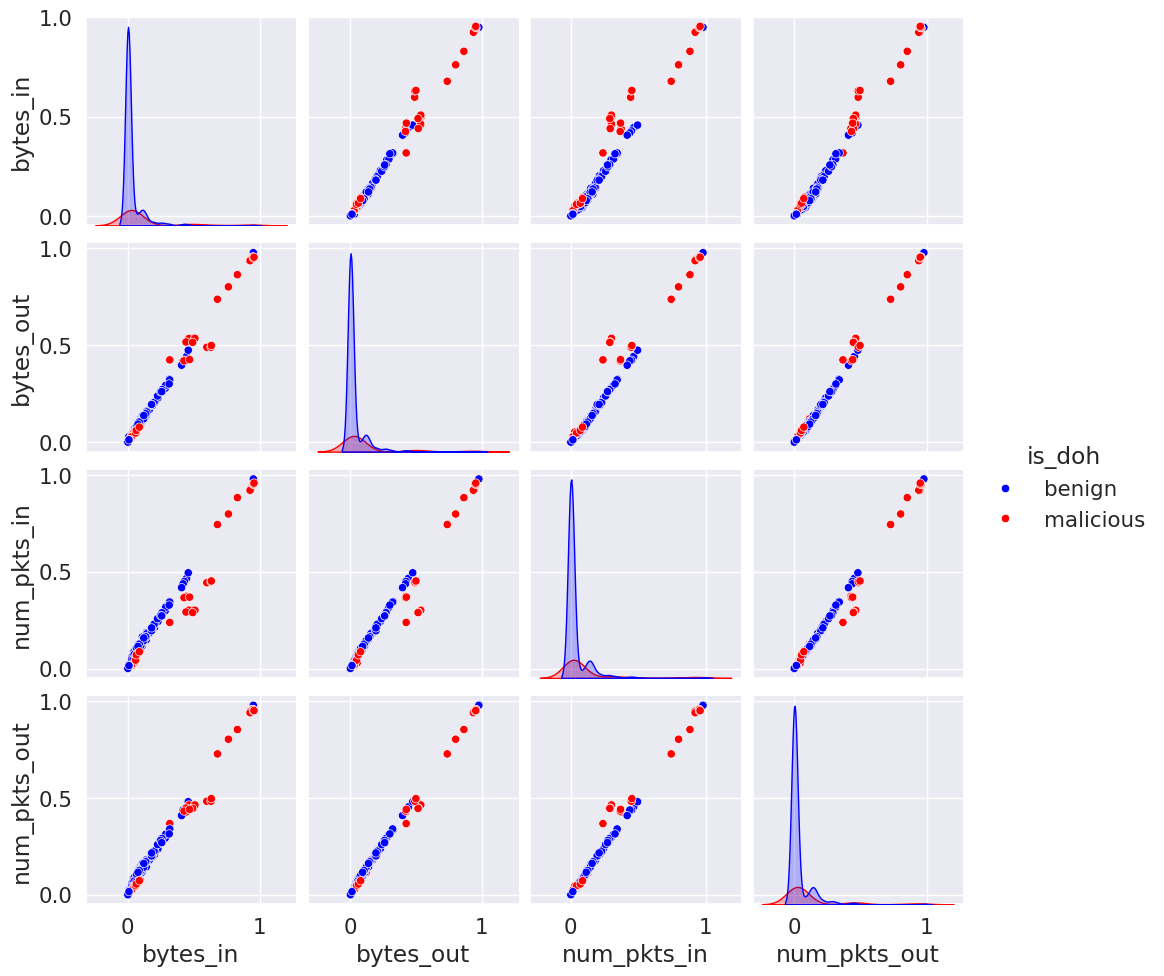

In [178]:
data_true[label_col][data_true[label_col] == -1] = "malicious"
data_true[label_col][data_true[label_col] == 1] = "benign"
subset1 = ['bytes_in', 'bytes_out', 'num_pkts_in', 'num_pkts_out']
sns.pairplot(data_true, vars= subset1, diag_kind='kde', hue=label_col, palette= {'malicious':'red','benign':'blue' })
plt.show

### Local Outlier Factor

Local outlier factor (LOF) calculates the density of neighbors for each sample in the dataset. Samples with low density are considered outliers. The density tells us how isolated a samples is from other samples. If the sample's nighbors have many neighbors but our sample doesn't, it is an outlier. The size of the circles in the figure show the outlier score (inverse of density). 

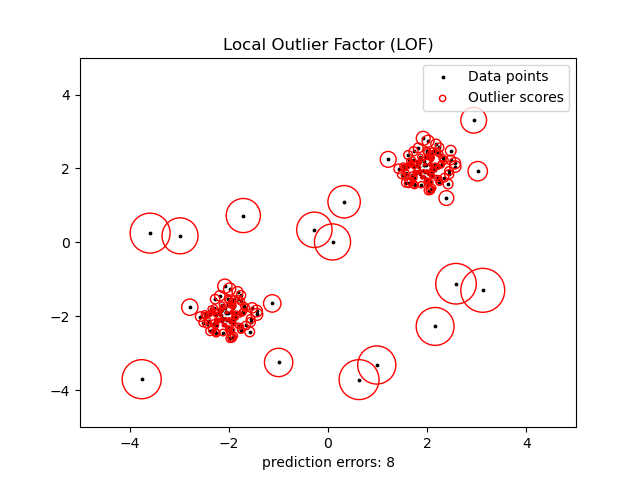
Source: [Scikit-Learn](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html)

####  Training a Local Outlier Factor Model
We show a sample LOF training. However, we have not optimized the parameters as we did IF. Read the
documentation for LOF function and modify its parameters to improve the perormance. 

In [184]:
from sklearn.neighbors import LocalOutlierFactor

testing_samples = 600

tic = perf_counter()
model_lof = LocalOutlierFactor(novelty=True).fit(data_training.sample(n=testing_samples))
joblib.dump(model_lof, 'Local_Outlier_Factor.sav')
toc = perf_counter()
t_lof = toc-tic

In [ ]:
print('The LOF training time is:')
t_lof

### LOF Evaluation
The evaluation steps are the same for any ML model. Use the code from IF to plot the ROC curve and the
Confusion Matrix for the LOF Evaluation 

In [186]:
# Get anomaly scores for samples in the evaluation dataset
scores_lof  = model_lof.decision_function(data_testing)*-1

# Plot ROC Curve


#Plot Confusion Matrix

/usr/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


### Improving LOF Performance
By changing the parameters of LOF we can sometimes improve the performance,

 1. Number of neighbors used to compute the neighbor algorithm. 
 2. Distance metric. This metric calculates the distance to other samples from every sample in the dataset. In LOF, it tells us how close the evaluation samples are to training sample clusters. Depending on how the data is distributed in the hyperspace different metrics may have better results. 

## Performance Comparison
Which one had a better accuracy, precision, recall, F1-scores, etc.?
Which one had a faster training time? 